# Breast Cancer Detection Model U-Net

## 0. Import Module

- [OpenSlide](https://openslide.org/api/python/#module-openslide)

In [1]:
%matplotlib inline
import os
import csv
import cv2
import openslide
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from skimage.filters import threshold_otsu
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from openslide.deepzoom import DeepZoomGenerator

## 1. Patch Gen DataFrame

In [2]:
# slide path
slide_path = '../data/train/pos/16-S-042893_A1.mrxs'  # pos
# neg_slide_path = '../data/train/16-S-042725_A.mrxs'  # neg

# mask path
truth_path = '../data/train/pos/Mask_16-S-042893_A1.png'  # pos
# neg_mask_path = '../data/train/Mask_16-S-042725_A.png'  # neg

# openslide
## slide
slide = openslide.open_slide(slide_path)
# neg_slide = openslide.open_slide(neg_slide_path)
## mask
truth = openslide.open_slide(truth_path)
# neg_mask = openslide.open_slide(neg_mask_path)

In [3]:
print('origin slide.dimensions :', slide.dimensions)
# print('origin neg_slide.dimensions :', neg_slide.dimensions)
print('origin truth.dimensions :', truth.dimensions)
# print('origin neg_mask.dimensions :', neg_mask.dimensions)

origin slide.dimensions : (93970, 234042)
origin truth.dimensions : (5316, 10007)


In [4]:
def find_patches_from_slide(slide_path, 
                            truth_path, 
                            patch_size=256, 
                            filter_non_tissue=True):
    '''Returns a DataFrame of all patches in slide
        Args:
            - slide_path: path of slide
            - truth_path: path of truth(mask)
            - patch_size: patch size for samples
            - filter_non_tissue: remove samples no tissue detected
        Returns:
            - all_tissue_samples: patch samples from slide'''
    # 해당 데이터가 양성인지 판단
    slide_contains_tumor = 'pos' in slide_path

    # read_region을 위한 start, level, size 계산
    bounds_offset_props = (openslide.PROPERTY_NAME_BOUNDS_X, openslide.PROPERTY_NAME_BOUNDS_Y)
    bounds_size_props = (openslide.PROPERTY_NAME_BOUNDS_WIDTH, openslide.PROPERTY_NAME_BOUNDS_HEIGHT)

    with openslide.open_slide(slide_path) as slide:
        start = (int(slide.properties.get(bounds_offset_props[0], 0)), 
                 int(slide.properties.get(bounds_offset_props[1], 0)))
        level = int(np.log2(patch_size))

        size_scale = tuple(int(slide.properties.get(prop, dim)) / dim 
                           for prop, dim in zip(bounds_size_props, slide.dimensions))
        l_dimensions = [(int(np.ceil(dim_x * size_scale[0])), int(np.ceil(dim_y * size_scale[1])))
                        for dim_x, dim_y in slide.level_dimensions]
        size = l_dimensions[level]

        slide4 = slide.read_region(start, level, size)
        
    # is_tissue 부분
    slide4_grey = np.array(slide4.convert('L'))

    # background에 대한 작업
    slide4_not_black = slide4_grey[slide4_grey > 0]
    # thresh = threshold_otsu(slide4_not_black)
    ret, th = cv2.threshold(slide4_not_black, 0, 255, 
                            cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    binary = slide4_grey > 0  # black == 0
    h, w = slide4_grey.shape
    for i in range(h):
        for j in range(w):
            if slide4_grey[i, j] > ret:
                binary[i, j] = False

    # patch_df
    patches = pd.DataFrame(pd.DataFrame(binary).stack(), columns=['is_tissue'])
    patches['slide_path'] = slide_path
    
    # is_tumor 부분
    if slide_contains_tumor:
        with openslide.open_slide(truth_path) as truth:
            thumbnail_truth = truth.get_thumbnail(size)

        # truth pathes_df
        patches_y = pd.DataFrame(
                pd.DataFrame(np.array(thumbnail_truth.convert('L'))).stack())
        patches_y['is_tumor'] = patches_y[0] > 0

        # mask된 영역이 애매한 경우
        patches_y['is_all_tumor'] = patches_y[0] == 255
        patches_y.drop(0, axis=1, inplace=True)
        samples = pd.concat([patches, patches_y], axis=1)
    else: 
        samples = patches
        samples['is_tumor'] = False

    if filter_non_tissue:  # tissue인것만 가져오기
        samples = samples[samples.is_tissue == True]

    samples['tile_loc'] = list(samples.index)
    all_tissue_samples = samples[samples['is_tumor'] == False]
    all_tissue_samples = all_tissue_samples.append(samples[samples['is_all_tumor'] == True])
    return all_tissue_samples

## 2. Train data Gen

In [7]:
def generator(samples,
              slide_path,
              truth_path,
              batch_size,
              patch_size=256,
              shuffle=True):
    '''The generator for DataSet
        Args:
            - samples: DataFrame of samples
            - slide_path: path of slide 
            - truth_path: path of truth(mask)
            - batch_size: mini-batch size
            - patch_size: patch size for samples
            - shuffle: bool, if True shuffle samples
        Returns(yield):
            - train_x: train dataset → [batch_size, patch_size, patch_size, 3]
            - train_y: train labelset → [batch_size, patch_size, patch_size, 2]
    '''
    
    slide = openslide.open_slide(slide_path)

    # tiles
    tiles = DeepZoomGenerator(slide, tile_size=patch_size, 
                              overlap=0, limit_bounds=False)

    start_x = int(slide.properties.get('openslide.bounds-x', 0)) / patch_size
    start_y = int(slide.properties.get('openslide.bounds-y', 0)) / patch_size
    
    num_samples = len(samples)
    slide_contains_tumor = 'pos' in slide_path
    if slide_contains_tumor:
        truth = openslide.open_slide(truth_path)
        truth_tiles = DeepZoomGenerator(truth, tile_size=16,  # tile_size=16인 이유는 mask가 원본의 1/16이어서 그런가?
                                        overlap=0, limit_bounds=False)

    while 1:
        if shuffle:
            samples = samples.sample(frac=1)  # shuffling

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]

            batch_tiles, batch_masks = [], []
            for y, x in batch_samples['tile_loc'].values:
                img = tiles.get_tile(tiles.level_count-1, (x+start_x, y+start_y))

                if slide_contains_tumor:
                    mask_tile = truth_tiles.get_tile(truth_tiles.level_count-1, (x, y))
                    mask_tile = cv2.cvtColor(np.array(mask_tile), cv2.COLOR_RGB2GRAY)
                    mask_tile_zoom = cv2.resize(mask_tile, (patch_size, patch_size), 
                                                interpolation=cv2.INTER_LINEAR)
                    mask_tile_zoom = mask_tile_zoom.astype(int) / 255.
                
                batch_tiles.append(np.array(img))
                batch_masks.append(mask_tile_zoom)
                
            # train_x & train_y
            train_x = np.array(batch_tiles) / 255.
            train_y = to_categorical(np.array(batch_masks), num_classes=2)
            yield train_x, train_y

## 3. Modeling

In [13]:
K.clear_session()

patch_size = 256

# Build U-Net model
inputs = layers.Input(shape=(patch_size, patch_size, 3), dtype='float32', name='inputs')

# Conv layers
conv1 = layers.Conv2D(16, 3, padding='same', activation='relu')(inputs)
conv1 = layers.Dropout(0.1)(conv1)
conv1 = layers.Conv2D(16, 3, padding='same', activation='relu')(conv1)
pool1 = layers.MaxPooling2D()(conv1)

conv2 = layers.Conv2D(32, 3, padding='same', activation='relu')(pool1)
conv2 = layers.Dropout(0.1)(conv2)
conv2 = layers.Conv2D(32, 3, padding='same', activation='relu')(conv2)
pool2 = layers.MaxPooling2D()(conv2)

conv3 = layers.Conv2D(64, 3, padding='same', activation='relu')(pool2)
conv3 = layers.Dropout(0.2)(conv3)
conv3 = layers.Conv2D(64, 3, padding='same', activation='relu')(conv3)
pool3 = layers.MaxPooling2D()(conv3)

conv4 = layers.Conv2D(128, 3, padding='same', activation='relu')(pool3)
conv4 = layers.Dropout(0.2)(conv4)
conv4 = layers.Conv2D(128, 3, padding='same', activation='relu')(conv4)
pool4 = layers.MaxPooling2D()(conv4)

conv5 = layers.Conv2D(256, 3, padding='same', activation='relu')(pool4)
conv5 = layers.Dropout(0.3)(conv5)
conv5 = layers.Conv2D(256, 3, padding='same', activation='relu')(conv5)

# Up-Conv layers
up_conv6 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(conv5)
up_conv6 = layers.concatenate([up_conv6, conv4])
conv6 = layers.Conv2D(128, 3, padding='same', activation='relu')(up_conv6)
conv6 = layers.Dropout(0.2)(conv6)
conv6 = layers.Conv2D(128, 3, padding='same', activation='relu')(conv6)

up_conv7 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(conv6)
up_conv7 = layers.concatenate([up_conv7, conv3])
conv7 = layers.Conv2D(64, 3, padding='same', activation='relu')(up_conv7)
conv7 = layers.Dropout(0.2)(conv7)
conv7 = layers.Conv2D(64, 3, padding='same', activation='relu')(conv7)

up_conv8 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(conv7)
up_conv8 = layers.concatenate([up_conv8, conv2])
conv8 = layers.Conv2D(32, 3, padding='same', activation='relu')(up_conv8)
conv8 = layers.Dropout(0.1)(conv8)
conv8 = layers.Conv2D(32, 3, padding='same', activation='relu')(conv8)

up_conv9 = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(conv8)
up_conv9 = layers.concatenate([up_conv9, conv1])
conv9 = layers.Conv2D(16, 3, padding='same', activation='relu')(up_conv9)
conv9 = layers.Dropout(0.1)(conv9)
conv9 = layers.Conv2D(16, 3, padding='same', activation='relu')(conv9)

outputs = layers.Conv2D(2, 1, activation='softmax')(conv9)

unet = models.Model(inputs, outputs)
unet.compile(optimizer='adam',
             loss='categorical_crossentropy', 
             metrics=['acc'])

In [14]:
unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         inputs[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
__________________________________________________________________________________________________
max_poolin

In [15]:
# from IPython.display import Image
# from tensorflow.keras.utils import plot_model

# plot_model(unet, to_file='./plot-model/unet.png')
# Image(filename='./plot-model/unet.png')

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

###################
# Training Params #
###################
num_samples = 10000
batch_size = 32
n_epochs = 30

samples = find_patches_from_slide(slide_path, truth_path)
samples = samples.sample(num_samples, random_state=42)
samples.reset_index(drop=True, inplace=True)
num_samples = len(samples)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(samples, samples["is_tumor"]):
        train_samples = samples.loc[train_index]
        validation_samples = samples.loc[test_index]

In [22]:
train_gen = generator(train_samples, slide_path,
                      truth_path, batch_size)
val_gen = generator(validation_samples, slide_path,
                    truth_path, batch_size)

In [15]:
%%time
history = unet.fit_generator(train_gen, 
                             steps_per_epoch=np.ceil(len(train_samples)/batch_size),
                             epochs=n_epochs,
                             validation_data=val_gen,
                             validation_steps=np.ceil(len(validation_samples)/batch_size))

Epoch 1/30
250/250 [==============================] - 59s 236ms/step - loss: 15.8663 - acc: 0.7452 - val_loss: 11.9481 - val_acc: 0.8607
Epoch 2/30
250/250 [==============================] - 55s 220ms/step - loss: 9.4231 - acc: 0.8823 - val_loss: 10.4987 - val_acc: 0.8856
Epoch 3/30
250/250 [==============================] - 55s 221ms/step - loss: 8.0347 - acc: 0.9000 - val_loss: 6.9687 - val_acc: 0.9022
Epoch 4/30
250/250 [==============================] - 55s 221ms/step - loss: 7.5606 - acc: 0.9062 - val_loss: 6.3437 - val_acc: 0.9194
Epoch 5/30
250/250 [==============================] - 55s 221ms/step - loss: 6.3193 - acc: 0.9208 - val_loss: 10.8085 - val_acc: 0.8689
Epoch 6/30
250/250 [==============================] - 55s 220ms/step - loss: 6.3673 - acc: 0.9212 - val_loss: 5.8900 - val_acc: 0.9263
Epoch 7/30
250/250 [==============================] - 55s 220ms/step - loss: 5.7012 - acc: 0.9299 - val_loss: 5.1098 - val_acc: 0.9400
Epoch 8/30
250/250 [==============================]

In [16]:
unet.save('./model/unet.h5')

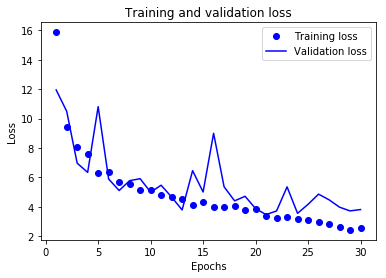

In [17]:
# Plotting
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

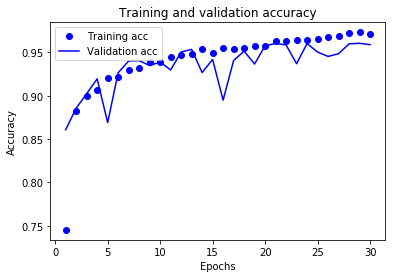

In [18]:
plt.clf()   # 그래프를 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4. Evaluate

In [17]:
unet = models.load_model('./model/unet.h5')
# unet.summary()

In [26]:
val_x, val_y = next(val_gen)

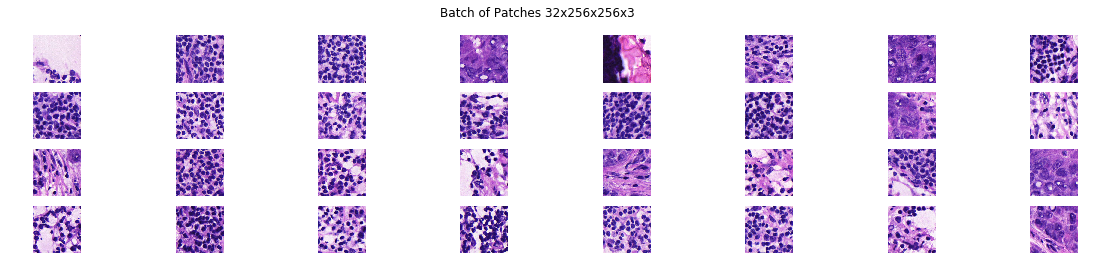

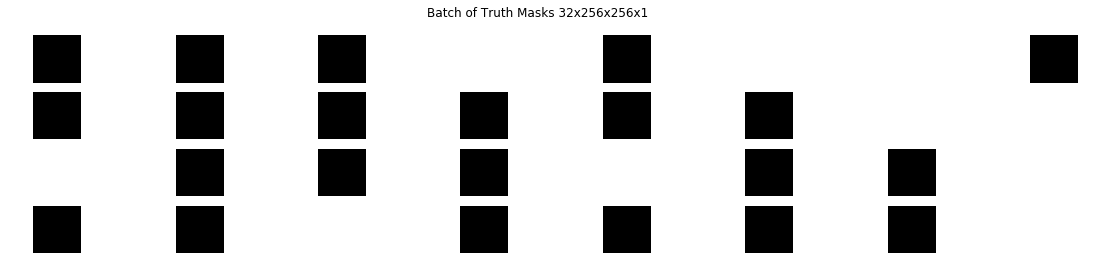

In [53]:
f, axes = plt.subplots(4, 8, figsize=(20, 4));
ax = axes.flatten()
for i in range(0, val_x.shape[0]):
    _ = ax[i].imshow(val_x[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(4, 8, figsize=(20, 4));
ax = axes.flatten()    
for i in range(0, val_x.shape[0]):
    _ = ax[i].imshow(val_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');

In [60]:
example_patch = val_x[5]
example_truth = val_y[5]

prediction = unet.predict(example_patch.reshape([1, 256, 256, 3]))
prediction = prediction[:, :, :, 1].reshape([256, 256])

In [61]:
import matplotlib.gridspec as gridspec

def plot_blend(patch, prediction, ax, alpha=0.75):
    """alpha blend patch and prediction.
    https://matplotlib.org/examples/pylab_examples/layer_images.html
    
    input: patch: 256x256x3, rgb image
    input: prediction: 256x256x1, per-pixel tumor probability
    input: ax: maplotlib Axes object
    input: alpha: alpha blend
    """
    
    dx, dy = 0.05, 0.05
    x = np.arange(0, patch.shape[1] - 1, dx)
    y = np.arange(0, patch.shape[0] - 1, dy)
    xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
    extent = xmin, xmax, ymin, ymax

    # fig = plt.figure(frameon=False, figsize=(10, 5))
    Z1 = cv2.cvtColor((patch*255).astype('uint8'), 
                      code=cv2.COLOR_RGB2GRAY)
    Z2 = prediction

    im1 = ax.imshow(Z1, cmap='gray', extent=extent)
    im2 = ax.imshow(Z2, cmap='jet', alpha=alpha, vmin=0.0, vmax=1.0,
                     extent=extent)
    ax.axis('off');

def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.6):
    """
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: prediction: 256x256x1, per-pixel tumor probability
    """
    gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[:, 2])
    axc = plt.subplot(gs[:, 3])

    ax0.imshow(patch);
    ax0.set_title('Original')
    
    ax1.imshow(truth.argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
    p = ax2.imshow(prediction, cmap='jet', vmin=0, vmax=1);
    ax2.set_title('Prediction heatmap')

    ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
    ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
    plot_blend(patch, prediction, ax4, alpha)
    ax4.set_title('Original+Prediction blend')
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.suptitle(title_str)
    fig.colorbar(p, cax=axc, orientation="vertical")
    axc.set_title('Probability pixel is tumor')

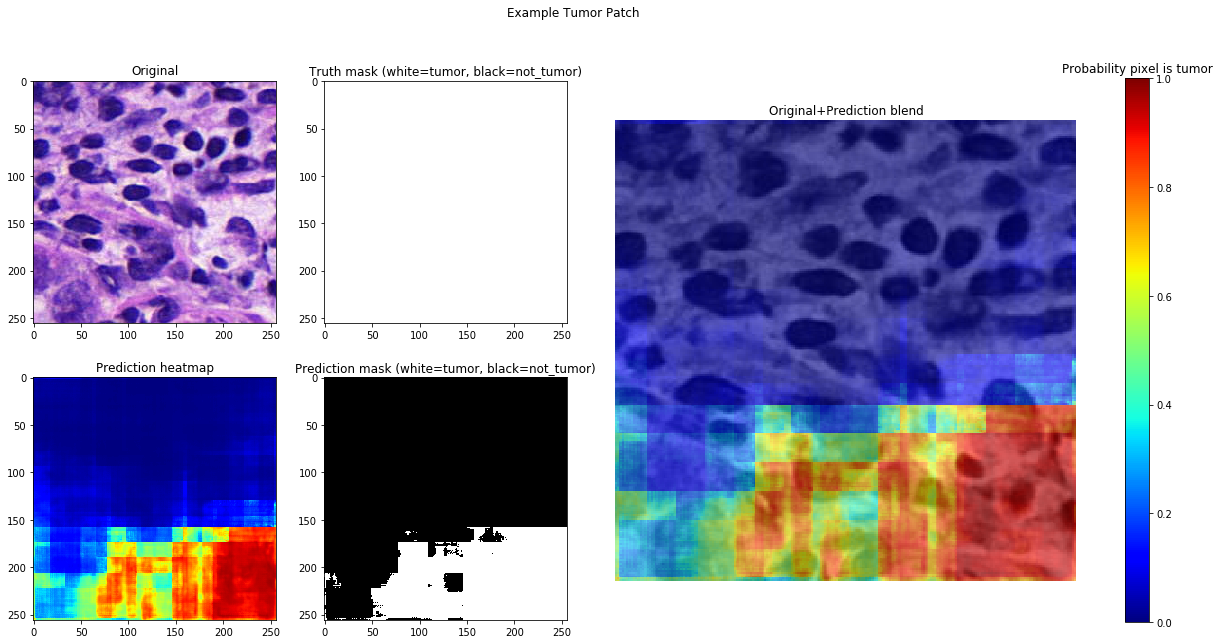

In [62]:
plot_patch_with_pred(example_patch, example_truth, 
                     prediction, title_str='Example Tumor Patch')